# Reinforcement Learning II: $Q$-learning

In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In this notebook we will investigate Q-learning and how to deal with an unknown state space. Therefore we define a class which stores q values in a lookup table.

In [1]:
class QValues(object):

    def __init__(self):
        '''Initialize with empty lookup table.'''
        self.values = {}

    def get_value(self, state, action):
        '''Return stored q value for (state, action) pair or a random number if unknown.'''
        if not state in self.values:
            self.values[state] = {}
        if not action in self.values[state]:
            self.values[state][action] = abs(np.random.randn()) + 1
        return self.values[state][action]

    def set_value(self, state, action, value):
        '''Stored q value for (state, action) pair.'''
        if not state in self.values:
            self.values[state] = {}
        if not action in self.values[state]:
            self.values[state][action] = 0

        self.values[state][action] = value

    def max_action(self, state, actions, learning=True):
        '''Return the action with highest q value for given state and action list.'''
        if not learning and not state in self.values:
            return actions[0] if actions else None

        max_value = -np.inf
        max_action = actions[0] if actions else None
        for action in actions:
            if not learning and not action in self.values[state]:
                continue

            value = self.get_value(state, action)
            if value > max_value:
                max_value = value
                max_action = action
            elif value == max_value and learning:
                max_action = np.random.choice([max_action, action])
        return max_action

    def epsilon_greedy(self, state, actions, epsilon):
        '''Returns max_action or random action with probability of epsilon.'''
        if np.random.rand() < epsilon:
            return np.random.choice(actions)
        return self.max_action(state, actions)

    def __str__(self):
        nr_states = len(self.values.keys())
        return 'Number of states: {}'.format(nr_states)

We can now add $(state, action)$ pairs to $Q$ and request pairs we haven’t set yet (which get initialised randomly).

In [3]:
q = QValues()
q.set_value(0, 'down', 1.2) #state,action, value
q.set_value(0, 'left', 0.5)
print(q.get_value(0, 'left'))
print(q.get_value(1, 'up'))
print(q.values)

0.5
1.34878804395466
{0: {'down': 1.2, 'left': 0.5}, 1: {'up': 1.34878804395466}}


We can also request the action with the highest q value in a given state $s$ for a list of actions. For the Monte Carlo approch we can also request the action with the highest q value with an $\epsilon$ chance of getting a random action.

In [4]:
print(q.max_action(0, ['down', 'left']))
for _ in range(10):
    print(q.epsilon_greedy(0, ['down', 'left'], epsilon=1.))

print('----------')

for _ in range(10):
    print(q.epsilon_greedy(0, ['down', 'left'], epsilon=0.05))


down
down
left
down
left
down
left
left
left
left
left
----------
down
down
down
down
down
down
down
down
down
down


Instead of an MDP we model the world as an environment. It holds the current state (e.g. coordinates of a robot) and defines the allowed actions in the current state (e.g. according to the current coordinates "drive left" or "drive ahead"). It allows the execution of an action and returns the next state and the reward for the action. 

In [5]:
class Environment(object):

    def __init__(self):
        '''Initialise  environment.'''
        pass

    def reset(self):
        '''Reset environment to initial state.'''
        pass

    def get_state(self):
        '''Return current state.'''
        pass

    def get_actions(self):
        '''Return all allowed actions as list (might be empty).'''
        pass

    def execute(self, action):
        '''Set internal state to the new state according to action and return (new_state, reward) tuple.'''
        pass

The following code is just a helper function to display a grid world example.

In [6]:
def draw_gridworld(env, path=[]):
    plt.plot()
    plt.xlim(-1, 2)
    plt.ylim(3, -1)
    plt.grid()
    plt.xticks([0,1])
    plt.yticks([0,1,2])
    plt.gca().set_xticklabels([])
    plt.gca().set_yticklabels([])

    plt.annotate('goal ' + str(env.goal), (env.goal[0]+0.25, env.goal[1]+0.5))
    plt.annotate('start' + str(env.start), (env.start[0]+0.25, env.start[1]+0.5))
    for (x1, y1), (x2, y2) in env.walls:
        if x1 == x2:
            plt.plot([x1, x1+1],[max(y1,y2), max(y1,y2)], c='k')
        else:
            plt.plot([max(x1,x2), max(x1,x2)], [min(y1, y2), min(y1, y2)+1], c='k')
    for (x,y), action in path:
        plt.scatter(x+0.5, y+0.5, s=100, marker={'left': '<', 'right':'>','up':'^', 'down':'v'}[action])

Lets define a grid word example as environment. We have a start, goal and current position. Each position is given in (x,y)-coordinates. The get_actions method allows 'left', 'right', 'up' and 'down' in any position except the final one. The reward for each action is -1. See how we can generate and infinite state space by just walking endless in one direction.

In [ ]:
class GridWorld(Environment):

    def __init__(self):
        self.start = (0, 0)
        self.goal = (0, 1)
        self.position = (0, 0)
        self.walls = []

    def reset(self):
        self.position = self.start

    def get_state(self):
        return self.position

    def get_actions(self):
        return [] if self.position == self.goal else ['left', 'right', 'up', 'down']

    def execute(self, action):
        position = self.get_state()
        move = {'left':(-1,0), 'right':(1,0), 'up':(0,-1), 'down':(0,1)}[action]
        self.position = (position[0] + move[0], position[1] + move[1])

        reward = -1.
        return position, reward

    def draw(self, path=[]):
        draw_gridworld(self, path)

For visualisation we display only the states around the start and goal.

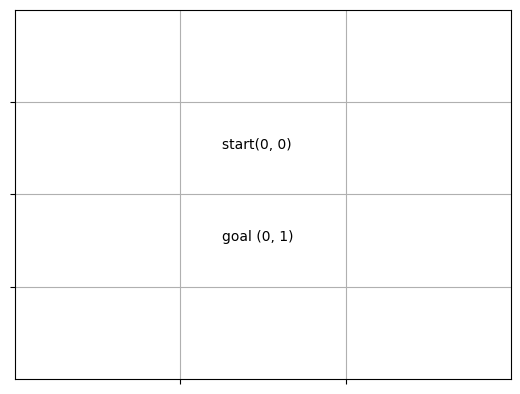

In [8]:
GridWorld().draw()

The following code shows how $Q$-learning can be implemented. Our implementation will use the environment to read the current state, get the possible actions and get the reward after choosing an action.

#### Q-learning Algorithm:

Initialize $Q(s,a)$ arbitrarily<br>
Repeat (for each episode):<br>
&nbsp;&nbsp;&nbsp;&nbsp;Initialize $s$<br>
&nbsp;&nbsp;&nbsp;&nbsp;Repeat (for each step of episode):<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Choose $a$ from $s$ using policy derived from $Q$ by $\epsilon$-greedy<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Take action $a$, observe $r, s'$<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$Q(s,a) \leftarrow Q(s,a) + \alpha [r+ \gamma $max$_{a'}Q(s',a')-Q(s,a)]$<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$s \leftarrow s'$<br>
&nbsp;&nbsp;&nbsp;&nbsp;until $s$ terminal<br>
Output $Q$

In [9]:
def q_learning(env, q=None, nr_episodes=100, nr_steps=100, epsilon=0.1, alpha=0.1, gamma=0.98):
    if not q:
        q = QValues()

    for _ in range(nr_episodes):
        env.reset()
        for _ in range(nr_steps):
            state = env.get_state()
            actions = env.get_actions()
            if not actions:
                break # final state reached

            action = q.epsilon_greedy(state, actions, epsilon)
            q_old = q.get_value(state, action)

            _, reward = env.execute(action) #take action
            next_state = env.get_state()
            next_max_action = q.max_action(next_state, env.get_actions())
            q_next = q.get_value(next_state, next_max_action)

            q_new = q_old + alpha * (reward + gamma * q_next - q_old)
            q.set_value(state, action, q_new)
    return q

We can now use the algorithm to derive $Q$ for the grid word example. From $Q$ we can get an optimal path by always choosing the actions with the highest expected reward.

(0, 0) down -> (0, 0)


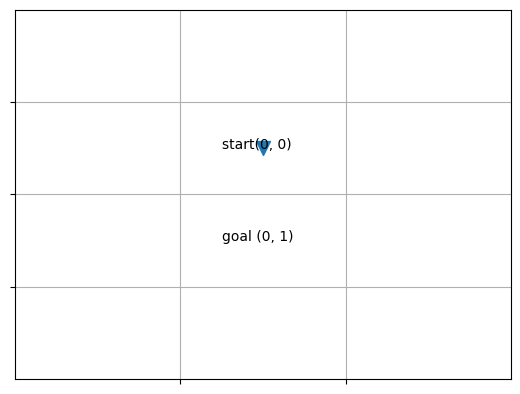

In [22]:
env = GridWorld()
q = q_learning(env, nr_episodes=100, nr_steps=100)

env.reset()
best_path = []
for _ in range (10):
    state = env.get_state()
    actions = env.get_actions()
    if not actions:
        break # final state reached

    action = q.max_action(state, actions, learning=False)
    next_state, _ = env.execute(action)
    print(state, action, '->', next_state)

    best_path.append((state, action))

env.draw(best_path)

As expected it was learned that the best state-action value from the initial state is down to the final state. Notice that during learning much more states where visited due to $\epsilon$-greedy policy.

In [21]:
print(q)

Number of states: 307



Lets create a new grid world environment by defining two walls (one between start and goal and one between goal and the field right to goal). Rewrite the execute method in such way that a an action that would cause a movement through a wall results in staying in the current position (state). The reward should be -1 in any case.

In [45]:
# Exercise

class GridWorld2(GridWorld):

    def __init__(self):
        self.start = (0, 0)
        self.goal = (0, 1)
        self.position = (0, 0)
        self.walls = [((0, 0), (0, 1)), # wall from (0,0) to (0,1)
                      ((0, 1), (1, 1))] # wall from (0,1) to (1,1)

    def execute(self, action):
         # Define the possible moves
        move = {'left':(-1,0), 'right':(1,0), 'up':(0,-1), 'down':(0,1)}[action]

        # Get the proposed new position based on the action
        new_position = (self.position[0] + move[0], self.position[1] + move[1])
       # print(new_position)

        reward=-1

        for wall_start,wall_end in self.walls:
            if(self.position == wall_start and new_position == wall_end) or (self.position == wall_end and new_position == wall_start):
                return self.position,reward
            
        #if no wall collision
        self.position=new_position
        return self.position, reward

When the code was implemented correct the optimal path found should be:

Position,  Action -> Next Position <br>
(0, 0),    left   -> (-1, 0)<br>
(-1, 0),   down   -> (-1, 1)<br>
(-1, 1),   right  -> (0, 1)<br>

(0, 0) left -> (-1, 0)
(-1, 0) down -> (-1, 1)
(-1, 1) right -> (0, 1)


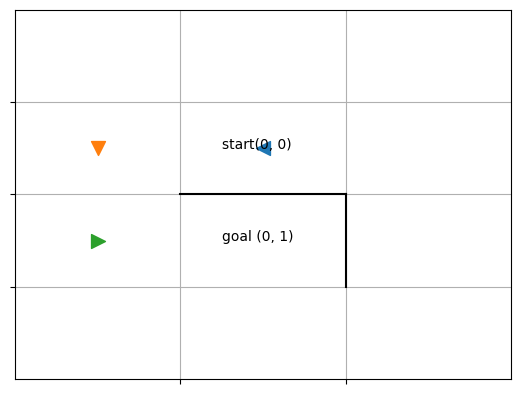

In [46]:
env = GridWorld2()
q = q_learning(env, nr_episodes=1000, nr_steps=100, epsilon=0.1, alpha=0.1, gamma=0.98)

env.reset()
best_path = []
for _ in range (10):
    state = env.get_state()
    actions = env.get_actions()
    if not actions:
        break # final state reached

    action = q.max_action(state, actions, learning=False)
    next_state, _ = env.execute(action)
    print(state, action, '->', next_state)

    best_path.append((state, action))

env.draw(best_path)

Lower the amount of episodes (nr_episodes) to different values.
At least try 10, 50, 200 and 500.

Plot the best path for each of the values.

Running Q-learning with 10 episodes...
Best path for 10 episodes:


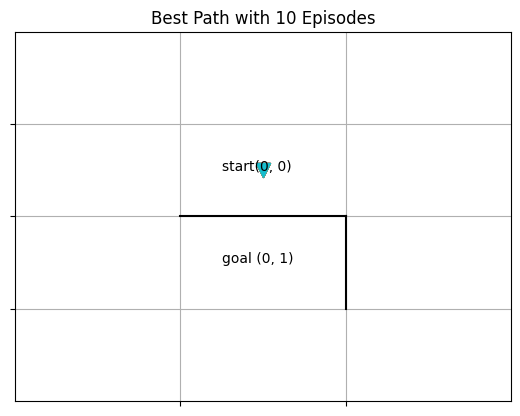

Running Q-learning with 50 episodes...
Best path for 50 episodes:


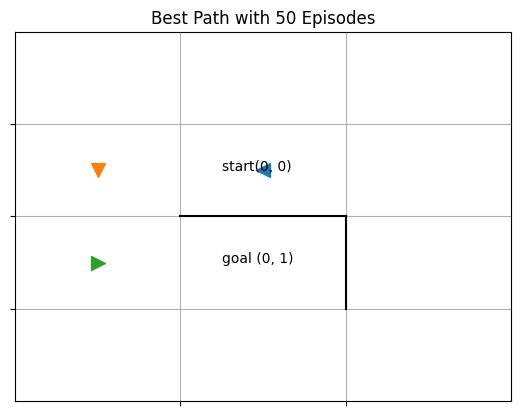

Running Q-learning with 200 episodes...
Best path for 200 episodes:


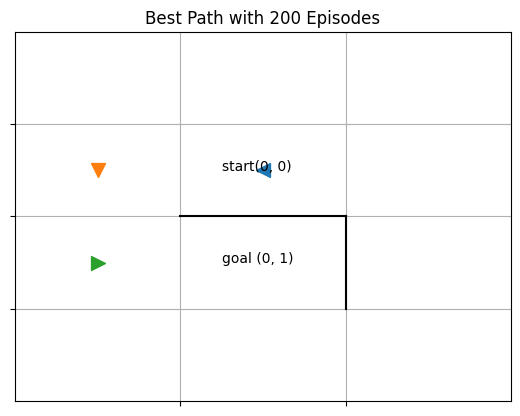

Running Q-learning with 500 episodes...
Best path for 500 episodes:


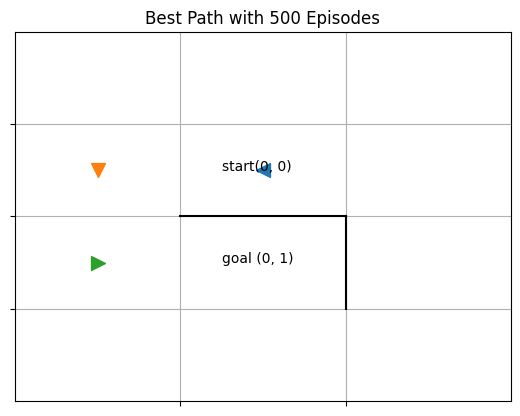

In [47]:
import matplotlib.pyplot as plt

# Test function to train and plot best path for different nr_episodes
def test_q_learning_with_different_episodes(env, episode_values=[10, 50, 200, 500]):
    # Loop over different values for nr_episodes
    for nr_episodes in episode_values:
        # Run Q-learning with the current number of episodes
        print(f"Running Q-learning with {nr_episodes} episodes...")
        q = q_learning(env, nr_episodes=nr_episodes, nr_steps=100)
        
        # Reset the environment
        env.reset()
        best_path = []

        # Generate best path using the trained Q-values
        for _ in range(10):  # Limit to 10 steps
            state = env.get_state()
            actions = env.get_actions()
            if not actions:
                break  # Goal reached

            action = q.max_action(state, actions, learning=False)
            next_state, _ = env.execute(action)

            best_path.append((state, action))

        # Plot the best path for this value of nr_episodes
        print(f"Best path for {nr_episodes} episodes:")
        env.draw(best_path)
        plt.title(f"Best Path with {nr_episodes} Episodes")
        plt.show()

# Test with different episode values
env = GridWorld2()  # Initialize the environment
test_q_learning_with_different_episodes(env, episode_values=[10, 50, 200, 500])



Now we will focus on trying out different environments

You will need to write your own environment class and apply $Q$-learning to it.

---

You may apply parameter optimisation techniques, like grid search, to find the best parameter for $\epsilon$, $\gamma$ and $\alpha$.

Therefore, you have to define a score function for the learned $Q$ values.

Try to find a convenient solution

We will start by creating a environment where both the goal and the start can be placed on any (random or chosen) location.




In [ ]:
#Edit this class

class random_GridWorld(Environment):

    def __init__(self):
        pass

    def reset(self):
        pass

    def get_state(self):
        pass

    def get_actions(self):
        pass

    def set_start(self,position):
        pass

    def set_goal(self,position):
        pass

    def execute(self, action):
        pass

    def draw(self, path=[]):
        pass

In [100]:
def draw_gridworld2(env, path=[]):
    plt.figure(figsize=(6, 6))
    plt.plot()
    plt.xlim(-1, env.size[0])
    plt.ylim(env.size[1], -1)
    plt.grid()
    plt.xticks(range(env.size[0]))
    plt.yticks(range(env.size[1]))
    plt.gca().set_xticklabels([])
    plt.gca().set_yticklabels([])

    # Annotate start and goal positions
    plt.annotate('Goal ' + str(env.goal), 
                 (env.goal[0] + 0.2, env.goal[1] + 0.5), 
                 fontsize=10, color='green')
    plt.annotate('Start ' + str(env.start), 
                 (env.start[0] + 0.2, env.start[1] + 0.5), 
                 fontsize=10, color='blue')

    # Draw walls
    for (x1, y1), (x2, y2) in env.walls:
        if x1 == x2:  # Vertical wall
            plt.plot([x1, x1], [min(y1, y2), max(y1, y2) + 1], color='black', linewidth=2)
        elif y1 == y2:  # Horizontal wall
            plt.plot([min(x1, x2), max(x1, x2) + 1], [y1, y1], color='black', linewidth=2)

    # Draw path
    for (x, y), action in path:
        plt.scatter(x + 0.5, y + 0.5, s=100, 
                    marker={'left': '<', 'right': '>', 'up': 'v', 'down': '^'}[action],
                    color='orange')

    plt.show()


In [101]:
import random

class random_GridWorld(Environment):
    def __init__(self, size=(5, 5)):
        self.size = size
        self.start = (0, 0)
        self.goal = (size[0]-1, size[1]-1)
        self.position = self.start
        self.walls = []
        
    def reset(self):
        '''Reset environment to initial state.'''
        self.position = self.start

    def get_state(self):
        '''Return current position.'''
        return self.position

    def get_actions(self):
        '''Return all allowed actions as list (might be empty).'''
        x, y = self.position
        actions = []
        
        # Can move up, down, left, right unless at borders or walls
        if x > 0: actions.append('left')   # Can move left
        if x < self.size[0] - 1: actions.append('right')  # Can move right
        if y > 0: actions.append('down')   # Can move down
        if y < self.size[1] - 1: actions.append('up')     # Can move up
        
        return actions

    def set_start(self, position):
        '''Set the start position.'''
        self.start = position
        self.position = position

    def set_goal(self, position):
        '''Set the goal position.'''
        self.goal = position

    def execute(self, action):
        '''Execute action and return new state, reward.'''
        x, y = self.position
        reward = -1  # Reward for each action is -1
        
        # Move based on action
        if action == 'left' and x > 0: 
            x -= 1
        elif action == 'right' and x < self.size[0] - 1:
            x += 1
        elif action == 'up' and y < self.size[1] - 1:
            y += 1
        elif action == 'down' and y > 0:
            y -= 1
        
        self.position = (x, y)
        
        # Goal reached: reward 0, terminate episode
        if self.position == self.goal:
            reward = 0
        return self.position, reward

    def draw(self, path=[]):
        draw_gridworld2(self, path)



# Score function: Evaluate learned Q-values based on how efficiently agent reaches goal
def evaluate_q_learning(env, q, max_steps=100):
    '''Evaluate the Q-learning agent by following the best path and counting steps.'''
    env.reset()
    total_steps = 0
    while total_steps < max_steps:
        state = env.get_state()
        actions = env.get_actions()
        if not actions:
            break  # Goal reached
        
        action = q.max_action(state, actions, learning=False)
        next_state, reward = env.execute(action)
        total_steps += 1
        
        if next_state == env.goal:
            break  # Reached the goal

    # Return the number of steps taken to reach the goal
    return total_steps

# Grid search for parameter optimization: test different values of epsilon, gamma, alpha
def grid_search(env, epsilons, gammas, alphas, nr_episodes=100, nr_steps=100):
    best_score = float('inf')
    best_params = None
    best_q = None
    
    # Iterate over parameter grid
    for epsilon in epsilons:
        for gamma in gammas:
            for alpha in alphas:
                print(f"Testing: epsilon={epsilon}, gamma={gamma}, alpha={alpha}")
                q = q_learning(env, nr_episodes=nr_episodes, nr_steps=nr_steps, epsilon=epsilon, gamma=gamma, alpha=alpha)
                
                # Evaluate the learned policy (Q-values) using score function
                score = evaluate_q_learning(env, q)
                
                print(f"Score (steps to goal): {score}")
                if score < best_score:
                    best_score = score
                    best_params = (epsilon, gamma, alpha)
                    best_q = q
    
    print(f"Best parameters: {best_params} with score: {best_score}")
    return best_q, best_params

# Example usage of grid search with different epsilon, gamma, and alpha values
env = random_GridWorld()
epsilons = [0.1, 0.2, 0.3]
gammas = [0.9, 0.95, 0.98]
alphas = [0.1, 0.5, 0.9]
best_q, best_params = grid_search(env, epsilons, gammas, alphas, nr_episodes=200, nr_steps=100)


Testing: epsilon=0.1, gamma=0.9, alpha=0.1
Score (steps to goal): 8
Testing: epsilon=0.1, gamma=0.9, alpha=0.5
Score (steps to goal): 8
Testing: epsilon=0.1, gamma=0.9, alpha=0.9
Score (steps to goal): 8
Testing: epsilon=0.1, gamma=0.95, alpha=0.1
Score (steps to goal): 100
Testing: epsilon=0.1, gamma=0.95, alpha=0.5
Score (steps to goal): 8
Testing: epsilon=0.1, gamma=0.95, alpha=0.9
Score (steps to goal): 8
Testing: epsilon=0.1, gamma=0.98, alpha=0.1
Score (steps to goal): 100
Testing: epsilon=0.1, gamma=0.98, alpha=0.5
Score (steps to goal): 8
Testing: epsilon=0.1, gamma=0.98, alpha=0.9
Score (steps to goal): 8
Testing: epsilon=0.2, gamma=0.9, alpha=0.1
Score (steps to goal): 100
Testing: epsilon=0.2, gamma=0.9, alpha=0.5
Score (steps to goal): 8
Testing: epsilon=0.2, gamma=0.9, alpha=0.9
Score (steps to goal): 8
Testing: epsilon=0.2, gamma=0.95, alpha=0.1
Score (steps to goal): 100
Testing: epsilon=0.2, gamma=0.95, alpha=0.5
Score (steps to goal): 8
Testing: epsilon=0.2, gamma=0.95

Train your model on a gridworld with the goal at (5,5) and two additional walls (4 total).

Plot the best path.

Best Path: [((0, 0), 'up'), ((0, 1), 'up'), ((0, 2), 'up'), ((0, 3), 'up'), ((0, 4), 'up'), ((0, 5), 'right'), ((1, 5), 'right'), ((2, 5), 'right'), ((3, 5), 'right'), ((4, 5), 'right')]


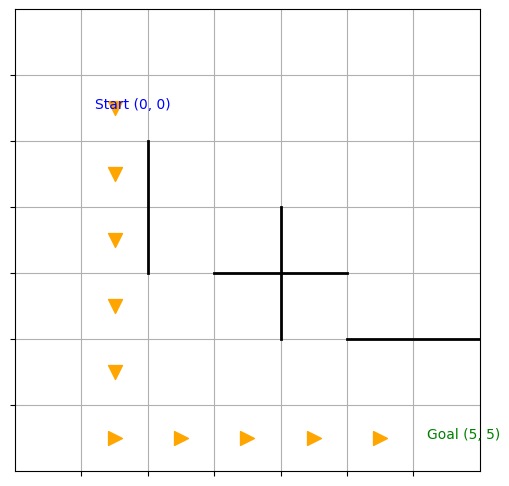

In [105]:
class GridWorldWithWalls(random_GridWorld):
    def __init__(self):
        super().__init__(size=(6, 6))
        self.start = (0, 0)
        self.goal = (5, 5)
        self.position = self.start
        self.walls = [((1, 1), (1, 2)),  # Wall 1
                      ((2, 3), (3, 3)),  # Wall 2
                      ((4, 4), (5, 4)),  # Wall 3
                      ((3, 2), (3, 3))]  # Wall 4

    def execute(self, action):
        '''Execute action considering walls and return new state and reward.'''
        x, y = self.position
        move = {'left': (-1, 0), 'right': (1, 0), 'up': (0, 1), 'down': (0, -1)}[action]
        new_position = (x + move[0], y + move[1])
        
        # Check if the move crosses any wall
        for wall in self.walls:
            if (self.position, new_position) in wall or (new_position, self.position) in wall:
                # Hit a wall: stay in the current position
                return self.position, -1
        
        # Update position if no wall blocks the move
        if 0 <= new_position[0] < self.size[0] and 0 <= new_position[1] < self.size[1]:
            self.position = new_position
        
        # Goal reached
        reward = 0 if self.position == self.goal else -1
        return self.position, reward

# Train the model on the new grid world
env = GridWorldWithWalls()
q = q_learning(env, nr_episodes=1000, nr_steps=100, epsilon=0.1, alpha=0.1, gamma=0.98)

# Derive the best path using the learned Q-values
env.reset()
best_path = []
for _ in range(20):  # Limit the number of steps to prevent infinite loops
    state = env.get_state()
    actions = env.get_actions()
    if not actions or state == env.goal:
        break  # Stop if no actions are possible or the goal is reached
    
    action = q.max_action(state, actions, learning=False)
    next_state, _ = env.execute(action)
    best_path.append((state, action))

# Visualize the best path
print("Best Path:", best_path)
env.draw(best_path)



Create your own Gridworld that is different to the previous environments in a significant way.

For example,

-Moving right causes you to move 2 grids instead of 1

-Add diagonal movement

-Create "booster" fields with a non-zero reward if stepped over once

Again don't forget to print the best path for each.

---

You may apply parameter optimisation techniques, like grid search, to find the best parameter for $\epsilon$, $\gamma$ and $\alpha$.

Therefore, you have to define a score function for the learned $Q$ values.


In [98]:
#Edit this class

class My_Own_GridWorld(Environment):

    def __init__(self):
        pass

    def reset(self):
        pass

    def get_state(self):
        pass

    def get_actions(self):
        pass

    def execute(self, action):
        pass

    def draw(self, path=[]):
        pass

In [114]:
def draw_gridworld3(env, path=[]):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(6, 6))
    plt.xlim(-1, env.size[0])
    plt.ylim(env.size[1], -1)
    plt.grid()
    plt.xticks(range(env.size[0]))
    plt.yticks(range(env.size[1]))
    plt.gca().set_xticklabels([])
    plt.gca().set_yticklabels([])

    # Annotate start and goal
    plt.annotate('Goal ' + str(env.goal), (env.goal[0] + 0.25, env.goal[1] + 0.5), color='green', weight='bold')
    plt.annotate('Start ' + str(env.start), (env.start[0] + 0.25, env.start[1] + 0.5), color='blue', weight='bold')

    # Draw walls
    for (x1, y1), (x2, y2) in env.walls:
        if x1 == x2:  # Vertical wall
            plt.plot([x1, x1], [min(y1, y2), max(y1, y2) + 1], c='k', linewidth=2)
        else:  # Horizontal wall
            plt.plot([min(x1, x2), max(x1, x2) + 1], [y1, y1], c='k', linewidth=2)

    # Highlight booster fields
    for (x, y), reward in env.boosters.items():
        plt.scatter(x + 0.5, y + 0.5, s=200, c='yellow', edgecolor='black', label=f'Booster {reward}')
    if env.boosters:
        plt.legend(loc='lower left', fontsize='small')

    # Plot path with arrows
    for (x, y), action in path:
        plt.scatter(x + 0.5, y + 0.5, s=100, marker={
            'left': '<', 'right': '>', 'up': '^', 'down': 'v',
            'up-left': '1', 'up-right': '2', 'down-left': '3', 'down-right': '4'
        }[action], c='red')

    plt.show()


In [116]:
class My_Own_GridWorld(Environment):
    def __init__(self):
        # Grid size and elements
        self.size = (5, 5)  # A 5x5 grid
        self.start = (0, 0)
        self.goal = (4, 4)
        self.position = (0, 0)
        self.boosters = {(1, 1): 5, (3, 3): 10}  # Booster fields with extra rewards
        self.walls = [((2, 2), (2, 3)), ((3, 1), (4, 1))]  # Walls
        self.move_cost = -1  # Cost for each move

    def reset(self):
        self.position = self.start

    def get_state(self):
        return self.position

    def get_actions(self):
        if self.position == self.goal:
            return []  # No actions possible at goal
        return ['left', 'right', 'up', 'down', 'up-left', 'up-right', 'down-left', 'down-right']

    def execute(self, action):
        current_position = self.get_state()
        # Define movement rules
        move = {
            'left': (-1, 0),
            'right': (2, 0),  # Move two grids to the right
            'up': (0, -1),
            'down': (0, 1),
            'up-left': (-1, -1),
            'up-right': (1, -1),
            'down-left': (-1, 1),
            'down-right': (1, 1)
        }[action]

        # Calculate the new position
        new_position = (current_position[0] + move[0], current_position[1] + move[1])

        # Check if the new position is out of bounds
        if (new_position[0] < 0 or new_position[0] >= self.size[0] or
                new_position[1] < 0 or new_position[1] >= self.size[1]):
            new_position = current_position

        # Check if the new position collides with walls
        if any(self._crosses_wall(current_position, new_position, wall) for wall in self.walls):
            new_position = current_position

        # Update the position
        self.position = new_position

        # Calculate the reward
        reward = self.move_cost
        if new_position in self.boosters:
            reward += self.boosters[new_position]

        return new_position, reward

    def _crosses_wall(self, pos1, pos2, wall):
        """Helper to check if a move crosses a wall."""
        (x1, y1), (x2, y2) = wall
        return (pos1, pos2) == wall or (pos2, pos1) == wall

    def draw(self, path=[]):
        draw_gridworld3(self, path)


Best Path: [((0, 0), 'down-right'), ((1, 1), 'down-right'), ((2, 2), 'down-right'), ((3, 3), 'right'), ((3, 3), 'right'), ((3, 3), 'right'), ((3, 3), 'right'), ((3, 3), 'right'), ((3, 3), 'right'), ((3, 3), 'right'), ((3, 3), 'right'), ((3, 3), 'right'), ((3, 3), 'right'), ((3, 3), 'right'), ((3, 3), 'right'), ((3, 3), 'right'), ((3, 3), 'right'), ((3, 3), 'right'), ((3, 3), 'right'), ((3, 3), 'right')]


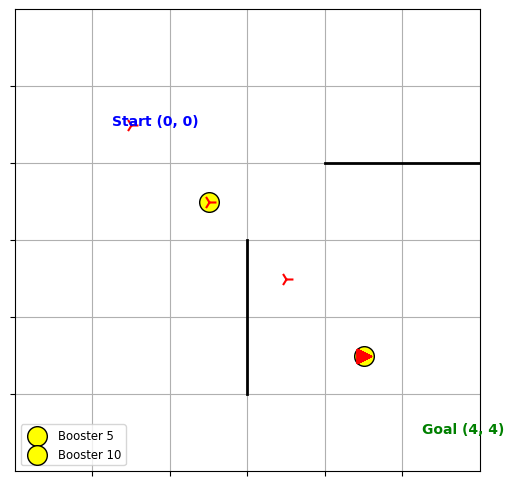

In [123]:
env = My_Own_GridWorld()
q = q_learning(env, nr_episodes=1000, nr_steps=100, epsilon=0.1, alpha=0.1, gamma=0.98)

env.reset()
best_path = []
for _ in range(20):
    state = env.get_state()
    actions = env.get_actions()
    if not actions or state == env.goal:
        break
    action = q.max_action(state, actions, learning=False)
    next_state, _ = env.execute(action)
    best_path.append((state, action))

print("Best Path:", best_path)
env.draw(best_path)
